In [1]:
from epi_model import *

In [2]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx
import matplotlib.pyplot as pyplot

# top level parameters

In [ ]:
T = 100 # time of the simulations
INIT_EXPOSED_PCT = 20/330 # initially exposed... this is modified later anyways now...

## Specifying contact networks

I'm doing it myself in this one

In [ ]:
tnet = temporalNetwork.load('high school2')

In [ ]:
counts = Counter([(i,j) for _,i,j in tnet.edgelist])

In [ ]:
max(sorted(tnet.G.nodes)) 

In [7]:
#nodes = sorted(tnet.nodes)
n2id = {n:i for i,n in enumerate(tnet.node_ids)}
#nodes = sorted(tnet.nodes)
#n2id2 = {n:i for i,n in enumerate(sim.tnet.nodes)}

In [8]:
wts = np.array([c/(30*60/20) for (i,j),c in counts.items()]) # 30 minutes ~= 1X transmissibility

In [9]:
G = nx.Graph()
G.add_weighted_edges_from( [(n2id[i], n2id[j], wts[ei]) for ei,((i,j),c) in enumerate(counts.items())] )

0.01, 0.07, 0.28, 1.06


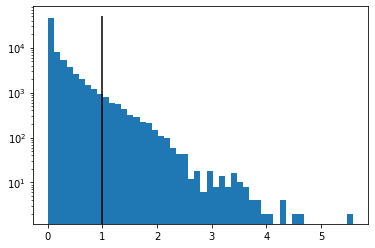

In [10]:
plt.hist( wts, bins=50, log=True );
plt.vlines(1,0,50000);
print( ", ".join([f"{x:0.2f}" for x in [np.quantile(wts,0.25), np.quantile(wts,0.50), np.quantile(wts,0.75), np.quantile(wts,0.95)]]) )

In [11]:
G_baseline = G
G_quarantine = G_baseline.copy()

In [12]:
Nn = len(G_baseline.nodes)
print(Nn)

784


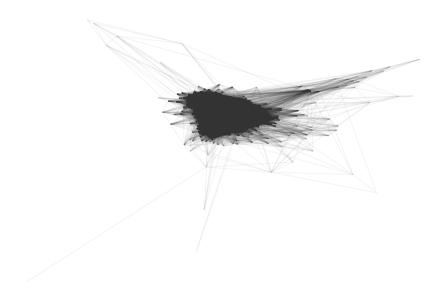

In [13]:
nx.draw(G, node_size=0, edge_color=(0.2,0.2,0.2,0.05))
#plt.xlim()

Baseline:
Degree: mean = 96.94, std = 38.31, 95% CI = (10.00, 161.00)
        coeff var = 0.40
Assortativity:    0.13
Clustering coeff: 0.27



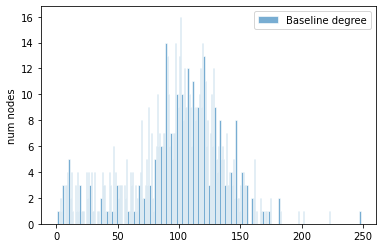

In [14]:
network_info(G_baseline, "Baseline", plot=True)

# args

In [16]:
from generate_SEIRS import generate_params

784
Individual R0:  mean = 2.51, std = 0.52, 95% CI = (1.65, 3.68)



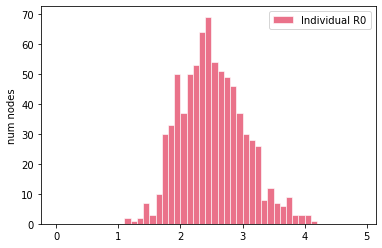

latent period:  mean = 2.27, std = 1.09, 95% CI = (0.66, 4.78)

pre-symptomatic period:  mean = 3.04, std = 1.90, 95% CI = (0.51, 8.00)

total incubation period:  mean = 5.31, std = 2.23, 95% CI = (2.06, 10.62)



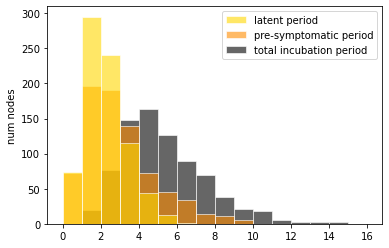

pre-symptomatic period:  mean = 2.27, std = 1.09, 95% CI = (0.66, 4.78)

(a)symptomatic period:  mean = 3.97, std = 1.54, 95% CI = (1.47, 7.26)

total infectious period:  mean = 6.23, std = 1.89, 95% CI = (2.98, 10.43)



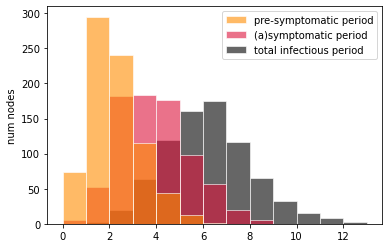

In [17]:
base_args = generate_params(G_baseline)

In [19]:
model = ExtSEIRSNetworkModel(**base_args)

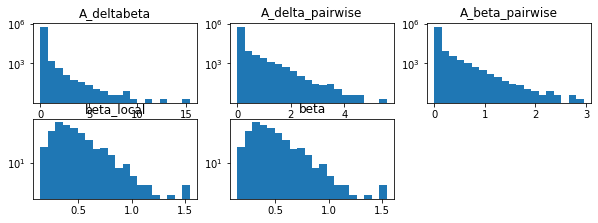

In [20]:
# parameters sanity check
names = "A_deltabeta,A_delta_pairwise,A_beta_pairwise,beta_local,beta".split(",")
sq = np.ceil(np.sqrt(len(names)))
plt.figure(figsize=(10,5))

for xi,x in enumerate(names):
    plt.subplot(sq,sq,xi+1)
    attr = getattr(model, x)
    if type(attr) == scipy.sparse.csr_matrix:
        attr = attr.toarray()
    plt.hist(attr.flatten(), bins=20, log=True);
    plt.title(x)
plt.show()

In [21]:
p = dict(params.covid_estimate)
sim = simulations.SEIR_daily(tnet, p)

In [22]:
n2id = {n:i for i,n in enumerate(tnet.nodes)}

In [24]:
attrs_to_keep = [k for k in model.__dict__ if 'num' == k[:3]]
attrs_to_keep += ['tseries']

In [25]:
def friendHighDegRandTop3(sim, vaccinateN):
    return sampling.friendHighDegRandTopN(sim, vaccinateN, N=3)
def friendHighDegRandTop5(sim, vaccinateN):
    return sampling.friendHighDegRandTopN(sim, vaccinateN, N=5)

In [26]:
strats = [
    sampling.friendHighDeg,
    sampling.targeted,
    sampling.none,
    sampling.rand,
    #sampling.friendHighDegClose,
    #sampling.friendClose,
    #sampling.friendWeightedChain,
]

strats += 1*[
    sampling.friend,
    sampling.friendHighDegChain,
    friendHighDegRandTop3,
    friendHighDegRandTop5,
]

In [36]:
models = defaultdict(list)

#with open('simulation_results/HS2_1.pickle', 'rb') as inf:
#    models = pickle.load(inf)

In [28]:
print("\n".join([
    f"{k}: {len(v)}" for k,v in models.items()
]))

In [47]:
import simulation_helper
from importlib import reload
reload(simulation_helper)
iter_args = simulation_helper.iter_args

In [30]:
from simulation_helper import *

In [48]:
argset1 = iter_args({
    'strat': {x.__name__: x for x in strats},
    'R0_mean': 2.5,
    'VACCINATE_P': [0.05, 0.10, 0.20, 0.50],
    'INITIAL_INFECT': 20
})
len(argset1)

argset2 = iter_args({
    'strat': {x.__name__: x for x in strats},
    'R0_mean': [1, 2.5, 4],
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': 20
})
len(argset2)

argset3 = iter_args({
    'strat': {x.__name__: x for x in strats},
    'R0_mean': 2.5,
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': [5, 10, 20]
})
len(argset3)

argsets = argset1 + argset2 + argset3
len(argsets)

80

In [49]:
N_PER = 200

In [50]:
N_iters = len(argsets) * N_PER

In [51]:
for argseti, (sname, argset) in enumerate(argsets):
    locals().update(argset)
    
    #if (argseti+1)%int(len(argsets)/100) == 0:
    print(f'Doing {sname}. {argseti}/{len(argsets)}. {N_PER - len(models[sname])} to do.')
    first_it = True

    for i in range(N_PER - len(models[sname])):

        ns_to_remove = strat(sim, int(Nn*VACCINATE_P))
        ns_to_remove = [n2id[x] for x in ns_to_remove]

        ALPHA = [0.5 if i not in ns_to_remove else 0 for i in range(Nn)]

        args = dict(base_args)
        args['alpha'] = ALPHA
        #args['initI_asym'] = INITIAL_INFECT

        model = ExtSEIRSNetworkModel(**args)

        # reconstruct X myself
        ns_to_infect = sample( [i for i in range(Nn) if i not in ns_to_remove], INITIAL_INFECT )

        for i in range(Nn):
            if i in ns_to_infect:
                model.X[i] = model.I_sym

        # hard-code this to avoid ridiculousness
        model.A_deltabeta = model.A

        # sanity checks
        assert all( 0<=i<=Nn for i in ns_to_remove )
        assert all( 0<=i<=Nn for i in ns_to_infect )

        st = time()
        model.run(100,verbose=False)
        if first_it:
            t_iter = time()-st
            print(f'{t_iter:0.1f} seconds for first simulation. At that rate it\'ll take {N_iters*t_iter/3600:0.1f} hours.')
            first_it = False

        models[sname].append({
            k: getattr(model, k)
            for k in attrs_to_keep
        })

Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friend'}). 0/80. 0 to do.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friend'}). 1/80. 126 to do.
2.3 seconds for first simulation. At that rate it'll take 10.2 hours.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friend'}). 2/80. 150 to do.
1.9 seconds for first simulation. At that rate it'll take 8.6 hours.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5, 'strat': 'friend'}). 3/80. 150 to do.
0.5 seconds for first simulation. At that rate it'll take 2.2 hours.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friendHighDeg'}). 4/80. 200 to do.
2.9 seconds for first simulation. At that rate it'll take 13.1 hours.
Doing frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friendHighDeg'}). 5/80. 200 to do.
2.7 seconds for first si

In [53]:
len(models)

64

In [54]:
nodes = tnet.nodes

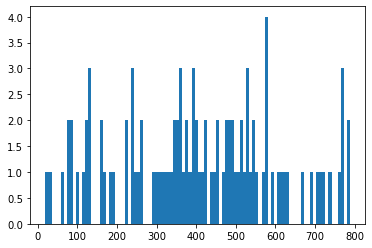

In [55]:
plt.hist(strat(sim,100), bins=100);

In [56]:
# sanity checks
who_got_infected = [x['infected_node'] for x in model.infectionsLog]

print(
    all( x in range(Nn) for x in strat(sim, 5) ),
    #all( n2id[ nodes[x] ] == x for x in strat(sim,100) ),
    tuple(sorted(sim.tnet.G.nodes)) == tuple(range(Nn)),
    all( x in range(Nn) for x in ns_to_remove ),
    tuple(sorted(tnet.G.edges)) == tuple(sorted(G.edges)), # this is crutial wtf...
    any(i in ns_to_remove for i in who_got_infected),
    len(who_got_infected), len(ns_to_infect), model.numS[:5], model.numS[-5:],
    all(i in ns_to_infect for i in who_got_infected),
)

True False True False False 512 10 [784. 774. 773. 773. 773.] [262. 262. 262. 262. 262.] False


In [57]:
print([len(m) for m in models.values()])

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


In [58]:
plt.figure(figsize=(20,20))

nsqrs = np.ceil( np.sqrt(len(models)) )

for ki,k in enumerate(sorted(models)):
    plt.subplot(nsqrs, nsqrs, ki+1)
    for i in range( min(30,len(models[k])) ):
        m = models[k][i]

        plt.plot(m['tseries'], m['numNodes'] - m['numS'], label=i, linewidth=1, color='black', alpha=0.5)
    #plt.legend()
    plt.title(k, fontsize=8)
    plt.ylim(0,m['numNodes'])

TypeError: '<' not supported between instances of 'frozendict' and 'frozendict'

<Figure size 1440x1440 with 0 Axes>

In [59]:
NAME = 'HS2_2'

with open(f'simulation_results/{NAME}.pickle', 'wb') as outf:
    pickle.dump(models, outf)

# bleh...
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'tolist'):
            return obj.tolist()
        if type(obj) == nx.classes.graph.Graph:
            return 'graph'
        return json.JSONEncoder.default(self, obj)
    
with open(f'simulation_results/{NAME}.args.json', 'w', encoding='utf8') as outf:
    json.dump(base_args, outf, cls=NumpyEncoder)

NameError: name 'json' is not defined